# FB Prophet-Final Model

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import holidays
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)


# Model 1 using  x.test as measure with extra graphs 

In [2]:
# Dataset already cleaned and merged with info from 2018-04-26 until 2020-01-31 as this was the most consistent 
# data before it got corrupted by the COVID.
train= pd.read_csv('2018-2020j_prophet.csv')

In [3]:
# Verifying the loaded data frame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  560 non-null    int64 
 1   Date        560 non-null    object
 2   Total       560 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
# Modifiying the column type as Prophet depends on this data for main calculations
train['Date'] = pd.to_datetime(train['Date'])

In [5]:
# Deleting unnecessary columns
train.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
# Renaming columns as Prophet works with these 2 specific names where ds is a datestamp and y is the data used to
# train the model
train.rename(columns={'Date': 'ds', 'Total': 'y'}, inplace=True)
df = train

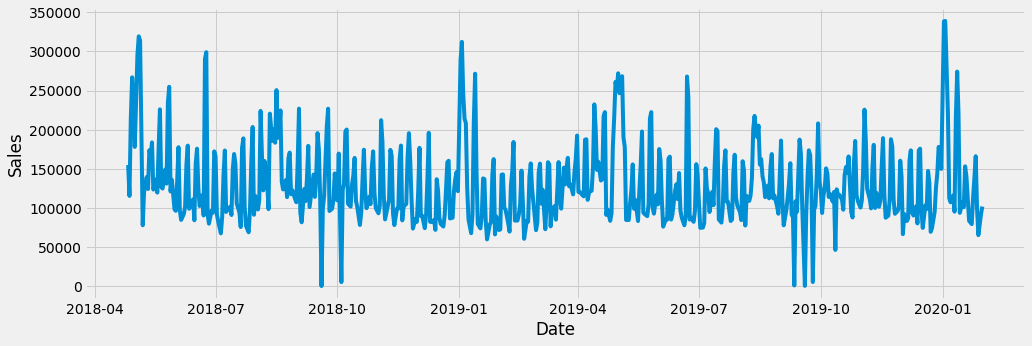

In [7]:
# Ploting dataset before prediction to understand what kind of flow it has.
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['ds'], df['y'], linestyle='-', label='All data')
ax.set_xlabel('Date')
ax.set_ylabel('Sales');

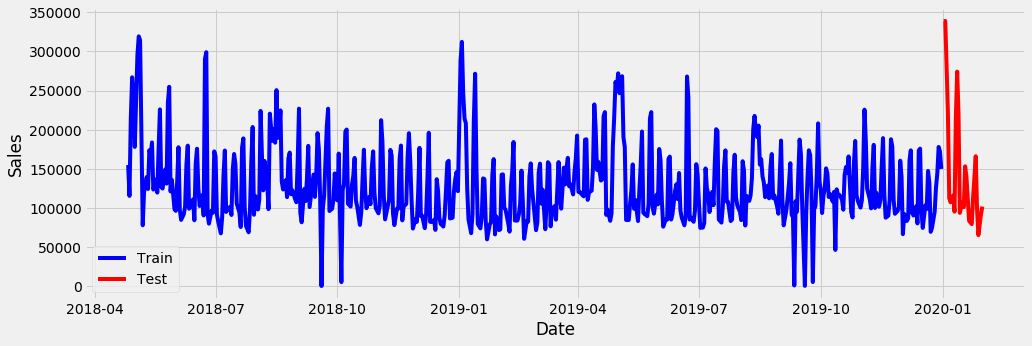

In [8]:
# Ploting train and test area for our dataset
# The number of tests is equal to the number of working days of the store.

n_test = 26
df_train = df[:-n_test]
df_test = df[-n_test:]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['ds'], df_train['y'], linestyle='-', color='blue', label='Train')
ax.plot(df_test['ds'],df_test['y'],linestyle='-', color='red', label='Test')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales');

In [9]:
# After looking into the data we can deduct that there is a seasonality plus points in time where sales increase 
# dramatically like at the beginning of each year. Prophet needs to know these change points in the timeline to
# make the forecast more precise and reliable.
# I call super holiday to the days where the sales were higher than a usual holiday. Like New Year's or Golden
# Week where the store is extremely busy.

events = pd.DataFrame({
    'holiday': 'event',
    'ds': pd.to_datetime(['2018-04-28', '2018-04-29', '2018-04-30', 
                          '2018-05-03', '2018-05-04', '2018-05-05',
                          '2018-05-20', '2018-05-26', '2018-05-27',
                          '2018-06-23', '2018-06-24', '2018-07-29',
                          '2018-08-04', '2018-08-11', '2018-08-12', 
                          '2018-08-14', '2018-08-16', '2018-08-19',
                          '2018-09-02', '2018-09-23', '2018-09-24',
                          '2018-10-08', '2018-11-03', 
                          '2019-01-02', '2019-01-03', '2019-01-04',
                          '2019-01-05', '2019-01-06', '2019-01-12', 
                          '2019-01-13', '2019-04-13', '2019-04-14',
                          '2019-04-20', '2019-04-21', '2019-04-28',
                          '2019-04-29', '2019-04-30', '2019-05-01',
                          '2019-05-02', '2019-05-03', '2019-05-04', 
                          '2019-05-25', '2019-05-26', '2019-06-22',
                          '2019-06-23', '2019-07-14', '2019-08-11',
                          '2019-08-12', '2019-08-15', '2019-09-29', 
                          '2019-11-03',
                          '2020-01-02', '2020-01-03', '2020-01-04',
                          '2020-01-05', '2020-01-11', '2020-01-12',
                          '2020-01-13', '2020-02-02', '2020-02-14',
                          '2020-02-23']),
    'lower_window':0,
    'upper_window':1,
})
superholidays = pd.DataFrame({
    'holiday': 'superholiday',
    'ds': pd.to_datetime(['2018-04-29', '2018-05-03', '2018-05-04',
                          '2018-05-05', '2018-05-27', '2018-06-23', 
                          '2018-06-24', '2018-08-04',
                          '2019-01-02', '2019-01-03', '2019-01-13',
                          '2019-04-29', '2019-04-30', '2019-05-01',
                          '2019-05-03', '2019-05-04', '2019-06-22',
                          '2020-01-02', '2020-01-03', '2020-01-04',
                          '2020-01-11']),
    'lower_window':0,
   'upper_window':1,
})
holidays = pd.concat((events, superholidays))


In [10]:
# Hyperparameters. This where the magic happens and Prophet can be set up to handle our data in a specific way.
# As you can see the holidays and super holidays DF has been pass plus other seasonalities. Also, I added Japanese
# national holidays to help Prophet to figure out certain parts of the data.
model = Prophet(holidays=holidays, 
            
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=False,
            
            seasonality_prior_scale=0.1,
            interval_width=0.95,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.15)
                                    
model.add_country_holidays(country_name='JP')
model.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [11]:
# Once the model is set up we can request the forecast and print a DF with all the information related with the
# prediction. In this case, I'm only interested in the Yhat column as is the main forecast.

forecast = model.predict(df)
forecast[['ds','yhat']].head()

ds           yhat
0 2018-04-26  123671.457227
1 2018-04-27  127383.692802
2 2018-04-28  225169.117408
3 2018-04-29  298311.897626
4 2018-04-30  259581.744040

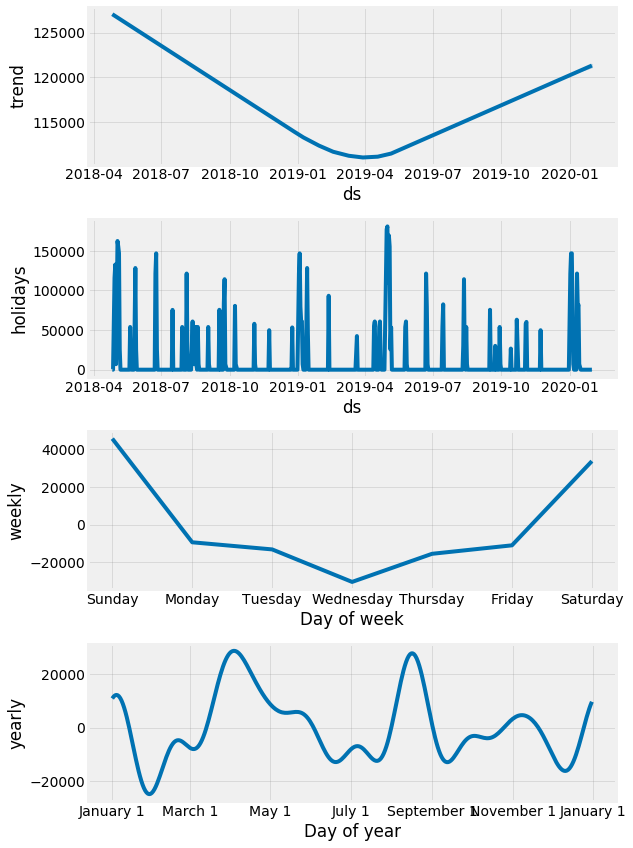

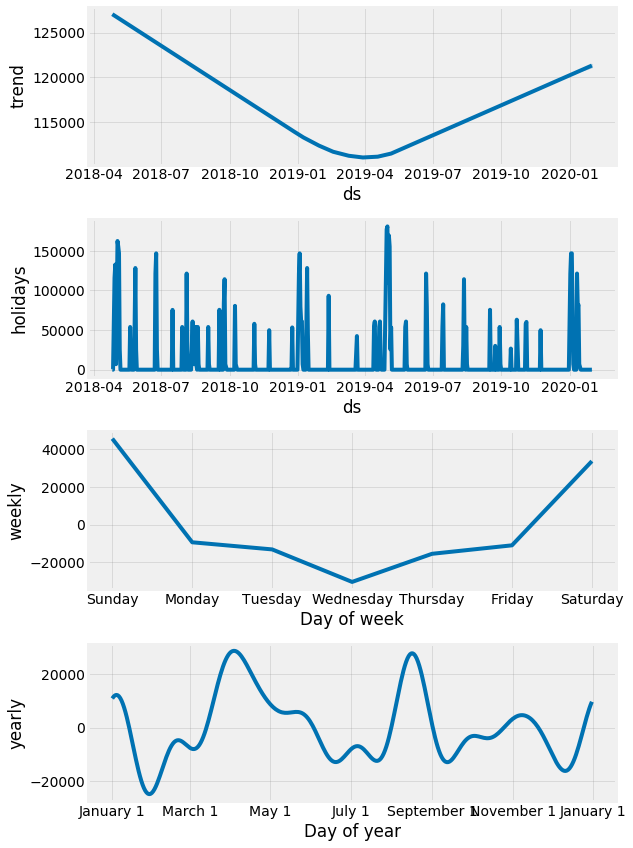

In [12]:
# Prophet already includes a series of plots that helps us to understand our data. As we can see Prophet understand
# very well our data.
model.plot_components(forecast)

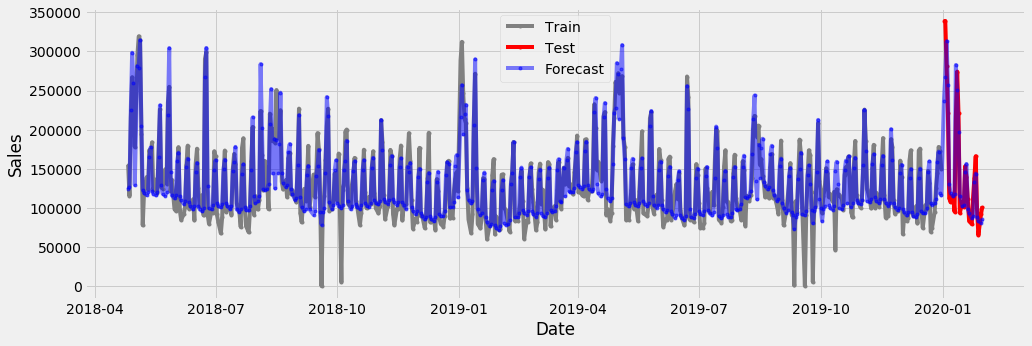

In [13]:
# From here we can visualize our trained and tested data and visually verify the accuracy. As we can see Prophet
# can forecast the higher points quite well but a little bit conservative in the lower points
# I left intentionally the most 5 lower points (These points are not necessary) to see how Prophet 
#responded to that. In Prophet documentation is recommended to always remove the outliers. 
#All outliers were removed during the cleaning process.


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['ds'], df_train['y'], c='grey', marker='o', ms=3, linestyle='-', label='Train')
ax.plot(df_test['ds'], df_test['y'], c='red', marker='o',ms=3, linestyle='-', label='Test')
ax.plot(forecast['ds'], forecast['yhat'], c='blue', marker='o', ms=3, linestyle='-', label='Forecast', alpha=0.5)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales');

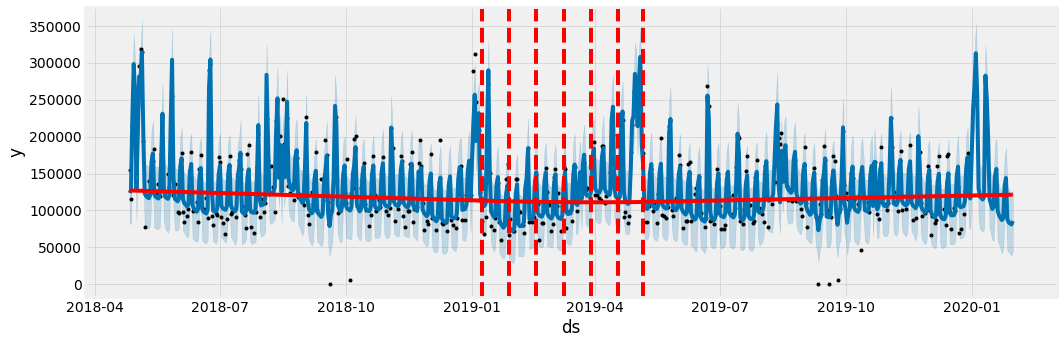

In [14]:
# In this plot we can see the trend that Prophet found in our data plus the change points. You can pass extra 
# change points to be more specific sharp changes in the data. As I already passed the holidays list I didn't 
# specify any extra change points or their sharpness. 

from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast,figsize=(15, 5))
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [15]:
# Prophet offers this dynamic plot that is very helpful during the testing stage of the model and helps to get
# insights about how the hyperparameters influence the forecast.
# The last line saves the plot to a html.

from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(model,forecast)
py.iplot(fig)
py.plot(fig, filename = 'filename.html', auto_open=False)

'filename.html'

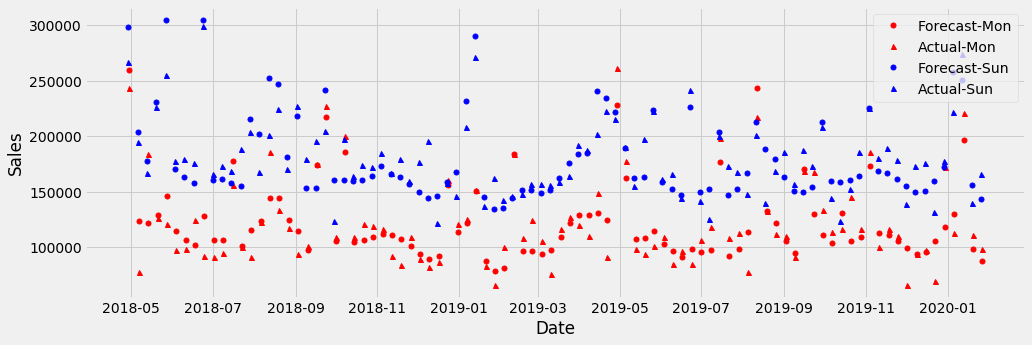

In [16]:
# This plot is very helpful to visualize 2 days of the week with their forecast and actual value so it is very 
# easy to understand how the model is behaving.
 

fig, ax = plt.subplots(figsize=(15, 5))
forecast['weekday'] = forecast['ds'].dt.weekday
df['weekday'] = df['ds'].dt.weekday
colors = ['r', 'g', 'yellow', 'pink', 'purple', 'cyan', 'blue']
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for wd in [0, 6]:
    fc_wd = forecast[forecast['weekday'] == wd]
    ax.plot(
        fc_wd['ds'], fc_wd['yhat'],
        c=colors[wd], marker='o', ms=5, linestyle='None',
        label=f'Forecast-{weekdays[wd]}')
    df_wd = df[df['weekday'] == wd]
    ax.plot(
        df_wd['ds'], df_wd['y'],
        c=colors[wd], marker='^', ms=5, linestyle='None',
        label=f'Actual-{weekdays[wd]}'
    )
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales');

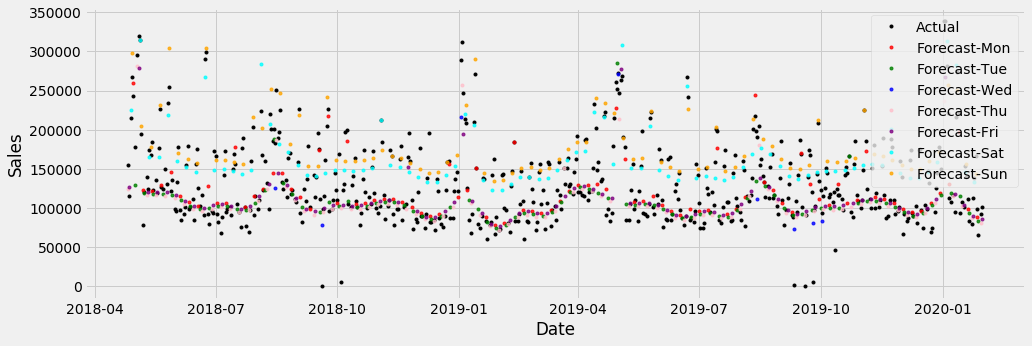

In [17]:
# We can do the same for all days of the week and look at the trends in our data.

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(
    df['ds'], df['y'],
    c='black', marker='o', ms=3, linestyle='None',
    label=f'Actual'
)

forecast['weekday'] = forecast['ds'].dt.weekday
colors = ['r', 'g', 'blue', 'pink', 'purple', 'cyan', 'orange']
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for wd in range(7):
    fc_wd = forecast[forecast['weekday'] == wd]
    ax.plot(
        fc_wd['ds'], fc_wd['yhat'],
        c=colors[wd], marker='o', ms=3, linestyle='None',
        label=f'Forecast-{weekdays[wd]}', alpha=0.8)

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales');

### Metrics

In [18]:
# Before go ahead with metrics is necessary to handle the forecast in a way is easy to calculate the metrics.
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat    yhat_lower     yhat_upper
555 2020-01-26  143981.109363  99765.583823  184873.832919
556 2020-01-27   88157.389667  45398.341614  132814.794023
557 2020-01-28   83779.065726  43589.649646  128473.523410
558 2020-01-30   81057.244792  38800.593199  121080.177782
559 2020-01-31   85752.054581  45207.488487  126778.854774

In [19]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [20]:
metric_df.tail(5)

ds           yhat       y
555 2020-01-26  143981.109363  166096
556 2020-01-27   88157.389667   99064
557 2020-01-28   83779.065726   65286
558 2020-01-30   81057.244792   92291
559 2020-01-31   85752.054581  101845

In [21]:
metric_df.dropna(inplace=True)

In [22]:
metric_df.tail()

ds           yhat       y
555 2020-01-26  143981.109363  166096
556 2020-01-27   88157.389667   99064
557 2020-01-28   83779.065726   65286
558 2020-01-30   81057.244792   92291
559 2020-01-31   85752.054581  101845

In [23]:
# R2 score to know how well the model adapts with the data.
r2_score(metric_df.y, metric_df.yhat)

0.8184024240199362

In [24]:
# The MSE is a measure of the quality of an estimator.
mean_squared_error(metric_df.y, metric_df.yhat)**0.5

22009.469354715897

In [25]:
# The MAE is a measure of errors between paired observations expressing the same phenomenon.
mean_absolute_error(metric_df.y, metric_df.yhat)

15695.30046482341

In [26]:
# Function to calculate the MAPE.
def mape(y_true, y_model):
    y_true, y_model=np.array(y_true), np.array(y_model)
    return np.mean(np.abs((y_true-y_model)/y_true))*100

In [27]:
# The measure of how accurate a forecast system is.
mape(metric_df.y, forecast.yhat)

110.84715313827924

In [28]:
# Correlation between the train and test data.
metric_df.loc['2020':,['y','yhat']].corr()

y      yhat
y     1.000000  0.905983
yhat  0.905983  1.000000

In [29]:
# The measure based on percentage (or relative) errors. Alternative measure to MAPE
y_true = df_test['y']
y_forecast = forecast[-n_test:]['yhat']
smape = ((y_true - y_forecast).abs() / (y_true.abs() + y_forecast.abs())).mean() * 200
print('The SMAPE error is:', smape)

The SMAPE error is: 13.949977563003134


In [30]:
# Prophet also offers their own tool to cross validate the data and offer insights about the model.
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, horizon='26 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 18 forecasts with cutoffs between 2019-04-28 00:00:00 and 2019-12-05 00:00:00


horizon           mse          rmse           mae      mape     mdape  \
0  3 days  5.494545e+08  23440.445579  16394.250594  2.425695  0.096795   
1  4 days  5.491602e+08  23434.168212  15611.324809  0.100696  0.076018   
2  5 days  6.476971e+08  25449.894169  16297.554131  0.110459  0.084830   
3  6 days  9.293690e+08  30485.554765  18926.335702  2.692022  0.092508   
4  7 days  1.028457e+09  32069.560026  21651.353633  3.090085  0.130900   

   coverage  
0  0.949785  
1  0.926829  
2  0.911585  
3  0.896341  
4  0.865041

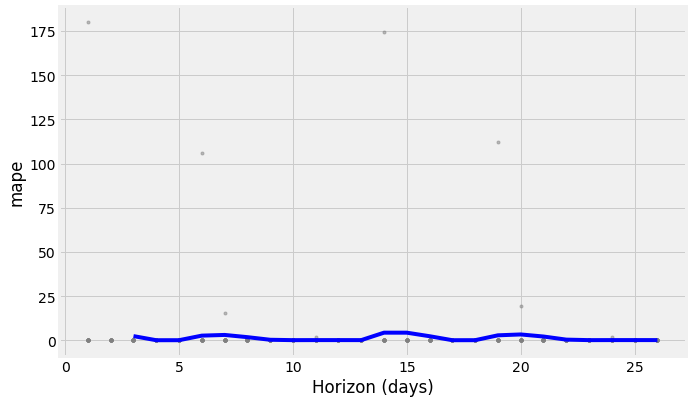

In [31]:
# We can plot the mape with the same tool to verify how well the model works.
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

In [32]:
# We can save our forecast in a CSV file for further analysis 
#metric_df.to_csv('Forecast2020J.csv')

# Model 1 without  x.text using Prophet normal method

### This second model was made following Prophet main documentation that differs from the usual x.test and x.train method. It is possible to obtain the same information but using x.test method (described above) will help to handle data easier.

In [33]:
# Dataset already cleaned and merged with info from 2018-04-26 until 2019-12-31 as this was the most consistent 
# data before got corrupted by the COVID.
df = pd.read_csv('2018-2019_prophet.csv')

In [34]:
# Renaming columns as Prophet works with these 2 specific names where ds is a datestamp and y is the data used to
# train the model
df= df.rename(columns={'Date': 'ds', 'Total': 'y'})

In [35]:
# Deleting unnecessary columns
df.drop(columns=['Unnamed: 0'], inplace=True)

In [36]:
# Modifiying the column type as Prophet depends on this data for main calculations
df['ds'] = pd.to_datetime(df['ds'])

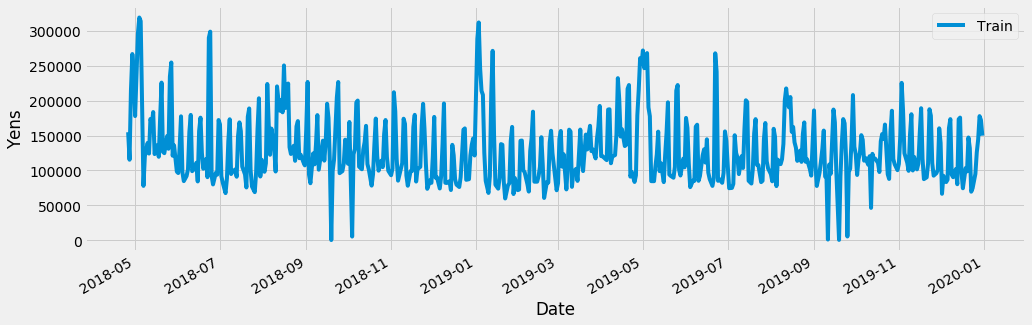

In [37]:
# Ploting dataset before prediction to understand what kind of flow it has.
ax = df.set_index('ds').plot(figsize=(15, 5))
plt.legend(['Train'])
ax.set_ylabel('Yens')
ax.set_xlabel('Date')

plt.show()

In [38]:
# After looking into the data we can deduct that there is a seasonality plus points in time where sales increase 
# dramatically like at the beginning of each year. Prophet needs to know these change points in the timeline to
# make the forecast more precise and reliable.
# I call super holiday to the days where the sales were higher than a usual holiday. Like New Year's or Golden
# Week where the store is extremely busy.

events = pd.DataFrame({
    'holiday': 'event',
    'ds': pd.to_datetime(['2018-04-28', '2018-04-29', '2018-04-30', 
                          '2018-05-03', '2018-05-04', '2018-05-05',
                          '2018-05-20', '2018-05-26', '2018-05-27',
                          '2018-06-23', '2018-06-24', '2018-07-29',
                          '2018-08-04', '2018-08-11', '2018-08-12', 
                          '2018-08-14', '2018-08-16', '2018-08-19',
                          '2018-09-02', '2018-09-23', '2018-09-24',
                          '2018-10-08', '2018-11-03', 
                          '2019-01-02', '2019-01-03', '2019-01-04',
                          '2019-01-05', '2019-01-06', '2019-01-12', 
                          '2019-01-13', '2019-04-13', '2019-04-14',
                          '2019-04-20', '2019-04-21', '2019-04-28',
                          '2019-04-29', '2019-04-30', '2019-05-01',
                          '2019-05-02', '2019-05-03', '2019-05-04', 
                          '2019-05-25', '2019-05-26', '2019-06-22',
                          '2019-06-23', '2019-07-14', '2019-08-11',
                          '2019-08-12', '2019-08-15', '2019-09-29', 
                          '2019-11-03',
                          '2020-01-02', '2020-01-03', '2020-01-04',
                          '2020-01-05', '2020-01-11', '2020-01-12',
                          '2020-01-13', '2020-02-02', '2020-02-14',
                          '2020-02-23']),
    'lower_window':0,
    'upper_window':1,
})
superholidays = pd.DataFrame({
    'holiday': 'superholiday',
    'ds': pd.to_datetime(['2018-04-29', '2018-05-03', '2018-05-04',
                          '2018-05-05', '2018-05-27', '2018-06-23', 
                          '2018-06-24', '2018-08-04',
                          '2019-01-02', '2019-01-03', '2019-01-13',
                          '2019-04-29', '2019-04-30', '2019-05-01',
                          '2019-05-03', '2019-05-04', '2019-06-22',
                          '2020-01-02', '2020-01-03', '2020-01-04',
                          '2020-01-11']),
    'lower_window':0,
   'upper_window':1,
})
holidays = pd.concat((events, superholidays))


In [39]:
# Hyperparameters. This where the magic happens and Prophet can be set up to handle our data in a specific way.
# As you can see the holidays and super holidays DF has been pass plus other seasonalities. Also, I added Japanese
# national holidays to help Prophet to figure out certain parts of the data.
m = Prophet(holidays=holidays, 
            
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=False,
            
            seasonality_prior_scale=0.1,
            interval_width=0.95,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.15)
                                    
m.add_country_holidays(country_name='JP')
m.fit(df)

In [40]:
# We need to specify hom many periods we would like to forecast, in this case we will forecast all January 2020
future = m.make_future_dataframe(periods = 31)
future.tail()

ds
560 2020-01-27
561 2020-01-28
562 2020-01-29
563 2020-01-30
564 2020-01-31

In [41]:
# In case you would like to see what holidays and super holidays are passed to the model
m.train_holiday_names

0             event
1      superholiday
2                元日
3              成人の日
4            建国記念の日
5              春分の日
6              昭和の日
7             憲法記念日
8             みどりの日
9             こどもの日
10              海の日
11              山の日
12             敬老の日
13             秋分の日
14             体育の日
15             文化の日
16           勤労感謝の日
17            天皇誕生日
18             振替休日
19          天皇の即位の日
20    即位礼正殿の儀が行われる日
21            国民の休日
dtype: object

In [42]:
# Once the model is set up we can request the forecast.
forecast = m.predict(future)

In [43]:
# We can print a DF with all the information about how the holidays influence the model.
forecast[(forecast['event'] + forecast['superholiday']).abs()>0][
        ['ds','event','superholiday']][-10:]

ds         event  superholiday
484 2019-11-04   6964.492663      0.000000
535 2020-01-02  53901.020968  67473.711521
536 2020-01-03  60865.513631  85968.410052
537 2020-01-04  60865.513631  85968.410052
538 2020-01-05  60865.513631  18494.698531
539 2020-01-06   6964.492663      0.000000
544 2020-01-11  53901.020968  67473.711521
545 2020-01-12  60865.513631  18494.698531
546 2020-01-13  60865.513631      0.000000
547 2020-01-14   6964.492663      0.000000

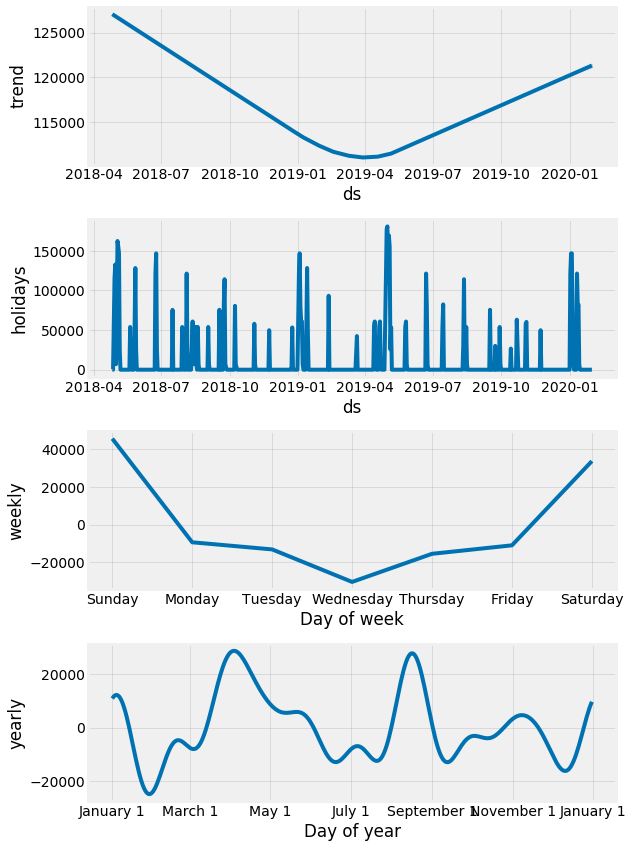

In [44]:
# Prophet already includes a series of plots that helps us to understand our data. As we can see Prophet understand
# very well our data.
fig1 = m.plot_components(forecast)

In [45]:
# Prophet offers this dynamic plot that is very helpful during the testing stage of the model and helps to get
# insights about how the hyperparameters influence the forecast.
# The last line saves the plot to a html.

from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m,forecast)
py.iplot(fig)

### Metrics

In [46]:
# Before go ahead with metrics is necessary to handle the forecast in a way is easy to calculate the metrics.
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower     yhat_upper
560 2020-01-27  88157.389667  46353.790632  131695.782898
561 2020-01-28  83779.065726  40710.595849  125124.852264
562 2020-01-29  66214.873756  24121.767097  109691.040276
563 2020-01-30  81057.244792  40449.319521  124447.047237
564 2020-01-31  85752.054581  41679.936732  123958.698097

In [47]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [48]:
metric_df.tail()

ds          yhat   y
560 2020-01-27  88157.389667 NaN
561 2020-01-28  83779.065726 NaN
562 2020-01-29  66214.873756 NaN
563 2020-01-30  81057.244792 NaN
564 2020-01-31  85752.054581 NaN

In [49]:
metric_df.dropna(inplace=True)

In [50]:
metric_df.tail()

ds           yhat         y
529 2019-12-27  112058.905794  125906.0
530 2019-12-28  158438.838505  144381.0
531 2019-12-29  172016.286481  177919.0
532 2019-12-30  118567.689332  172197.0
533 2019-12-31  116128.158878  149889.0

In [51]:
# R2 score to know how well the model adapts with the data.
r2_score(metric_df.y, metric_df.yhat)

0.8153938050971944

In [52]:
# The MSE is a measure of the quality of an estimator.
mean_squared_error(metric_df.y, metric_df.yhat)**0.5

21379.797062603557

In [53]:
# The MAE is a measure of errors between paired observations expressing the same phenomenon.
mean_absolute_error(metric_df.y, metric_df.yhat)

15339.577778144156

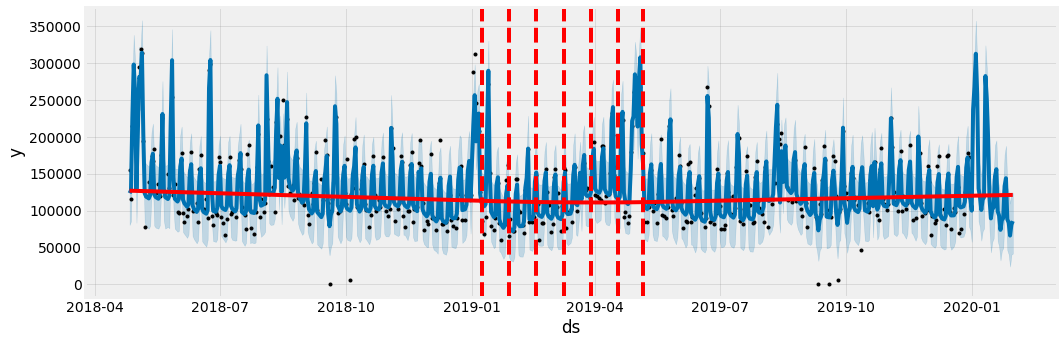

In [54]:
# In this plot we can see the trend that Prophet found in our data plus the change points. You can pass extra 
# change points to be more specific sharp changes in the data. As I already passed the holidays list I didn't 
# specify any extra change points or their sharpness. 

from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast,figsize=(15, 5))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [55]:
# We can save our forecast in a CSV file for further analysis 
#forecast.to_csv('forecast1819J.csv')